# NeRF: Representing Scenes as Neural Radiance Fields for View Synthesis
[三次元空間のニューラルな表現とNeRF](https://blog.albert2005.co.jp/2020/05/07/nerf/)で使用したノートブックです．

## 概要
- [著者プロジェクトページ](http://www.matthewtancik.com/nerf)
- 微分可能なレンダリングを介して，多視点画像から 3D オブジェクトを学習する．
- 各カメラの焦点からピクセル方向に直線を伸ばし，その上の各点 $(x, y, z, \theta, \phi)$ （ただし $\theta, \phi$ は視線の角度）に対し輝度と密度 $(R, G, B, \sigma)$ を出力する NN を作る．
- NN の出力を積算してレンダリング結果を生成し、これと実際の画像が一致するよう訓練する．

In [1]:
import glob
import os

import numpy as np
import pylab as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F

## NeRFの実装

### レンダリング用関数
- 本手法では「粗い」レンダリングと「細かい」レンダリングと２回レンダリングを行う．
- 粗いレンダリングでは，ほぼ等間隔な少数の点をもとにレンダリングし，細かいレンダリングでは粗いレンダリングで利用した各点の不透明度を用いて点を再サンプリングする．

In [2]:
def split_ray(t_n, t_f, N, batch_size):
    """Split the ray into N partitions.

    partition: [t_n, t_n + (1 / N) * (t_f - t_n), ..., t_f]

    Args:
        t_n (float): t_near. Start point of split.
        t_f (float): t_far. End point of split.
        N (int): Num of partitions.
        batch_size (int): Batch size.

    Returns:
        ndarray, [batch_size, N]: A partition.

    """
    partitions = np.linspace(t_n, t_f, N+1, dtype=np.float32)
    return np.repeat(partitions[None], repeats=batch_size, axis=0)


def sample_coarse(partitions):
    """Sample ``t_i`` from partitions for ``coarse`` network.

    t_i ~ U[t_n + ((i - 1) / N) * (t_f - t_n), t_n + (i / N) * (t_f - t_n)]

    Args:
        partitions (ndarray, [batch_size, N+1]): Outputs of ``split_ray``.

    Return:
        ndarray, [batch_size, N]: Sampled t.

    """
    t = np.random.uniform(
        partitions[:, :-1], partitions[:, 1:]).astype(np.float32)
    return t


def _pcpdf(partitions, weights, N_s):
    """Sample from piecewise-constant probability density function.

    Args:
        partitions (ndarray, [batch_size, N_p+1]): N_p Partitions.
        weights (ndarray, [batch_size, N_p]): The ratio of sampling from each
            partition.
        N_s (int): Num of samples.

    Returns:
        numpy.ndarray, [batch_size, N_s]: Samples.

    """
    batch_size, N_p = weights.shape

    # normalize weights.
    weights[weights < 1e-16] = 1e-16
    weights /= weights.sum(axis=1, keepdims=True)

    _sample = np.random.uniform(
        0, 1, size=(batch_size, N_s)).astype(np.float32)
    _sample = np.sort(_sample, axis=1)

    # Slopes of a piecewise linear function.
    a = (partitions[:, 1:] - partitions[:, :-1]) / weights

    # Intercepts of a piecewise linear function.
    cum_weights = np.cumsum(weights, axis=1)
    cum_weights = np.pad(cum_weights, ((0, 0), (1, 0)),
                         mode='constant')
    b = partitions[:, :-1] - a * cum_weights[:, :-1]

    sample = np.zeros_like(_sample)
    for j in range(N_p):
        min_j = cum_weights[:, j:j+1]
        max_j = cum_weights[:, j+1:j+2]
        a_j = a[:, j:j+1]
        b_j = b[:, j:j+1]
        mask = ((min_j <= _sample) & (_sample < max_j)).astype(np.float32)
        sample += (a_j * _sample + b_j) * mask

    return sample


def sample_fine(partitions, weights, t_c, N_f):
    """Sample ``t_i`` from partitions for ``fine`` network.

    Sampling from each partition according to given weights.

    Args:
        partitions (ndarray, [batch_size, N_c+1]): Outputs of ``split_ray``.
        weights (ndarray, [batch_size, N_c]):
            T_i * (1 - exp(- sigma_i * delta_i)).
        t_c (ndarray, [batch_size, N_c]): ``t`` of coarse rendering.
        N_f (int): num of sampling.

    Return:
        ndarray, [batch_size, N_c+N_f]: Sampled t.

    """
    t_f = _pcpdf(partitions, weights, N_f)
    t = np.concatenate([t_c, t_f], axis=1)
    t = np.sort(t, axis=1)
    return t


def ray(o, d, t):
    """Returns points on the ray.

    Args:
        o (ndarray, [batch_size, 3]): Start points of the ray.
        d (ndarray, [batch_size, 3]): Directions of the ray.
        t (ndarray, [batch_size, N]): Sampled t.

    Returns:
        ndarray, [batch_size, N, 3]: Points on the ray.

    """
    return o[:, None] + t[..., None] * d[:, None]


def _rgb_and_weight(func, o, d, t, N):
    batch_size = o.shape[0]

    x = ray(o, d, t)
    x = x.view(batch_size, N, -1)
    d = d[:, None].repeat(1, N, 1)

    x = x.view(batch_size * N, -1)
    d = d.view(batch_size * N, -1)

    # forward.
    rgb, sigma = func(x, d)

    rgb = rgb.view(batch_size, N, -1)
    sigma = sigma.view(batch_size, N, -1)

    delta = F.pad(t[:, 1:] - t[:, :-1], (0, 1), mode='constant', value=1e8)
    mass = sigma[..., 0] * delta
    mass = F.pad(mass, (1, 0), mode='constant', value=0.)

    alpha = 1. - torch.exp(- mass[:, 1:])
    T = torch.exp(- torch.cumsum(mass[:, :-1], dim=1))
    w = T * alpha
    return rgb, w


def volume_rendering_with_radiance_field(func_c, func_f, o, d, t_n, t_f,
                                         N_c, N_f, c_bg):
    """Rendering with Neural Radiance Field.

    Args:
        func_c: NN for coarse rendering.
        func_f: NN for fine rendering.
        o (ndarray, [batch_size, 3]): Start points of the ray.
        d (ndarray, [batch_size, 3]): Directions of the ray.
        t_n (float): Start point of split.
        t_f (float): End point of split.
        N_c (int): num of coarse sampling.
        N_f (int): num of fine sampling.
        c_bg (tuple, [3,]): Background color.

    Returns:
        C_c (tensor, [batch_size, 3]): Result of coarse rendering.
        C_f (tensor, [batch_size, 3]): Result of fine rendering.

    """
    batch_size = o.shape[0]
    device = o.device

    partitions = split_ray(t_n, t_f, N_c, batch_size)

    # background.
    bg = torch.tensor(c_bg, device=device, dtype=torch.float32)
    bg = bg.view(1, 3)

    # coarse rendering:
    _t_c = sample_coarse(partitions)
    t_c = torch.tensor(_t_c)
    t_c = t_c.to(device)

    rgb_c, w_c = _rgb_and_weight(func_c, o, d, t_c, N_c)
    C_c = torch.sum(w_c[..., None] * rgb_c, axis=1)
    C_c += (1. - torch.sum(w_c, axis=1, keepdims=True)) * bg

    # fine rendering.
    _w_c = w_c.detach().cpu().numpy()
    t_f = sample_fine(partitions, _w_c, _t_c, N_f)
    t_f = torch.tensor(t_f)
    t_f = t_f.to(device)

    rgb_f, w_f = _rgb_and_weight(func_f, o, d, t_f, N_f+N_c)
    C_f = torch.sum(w_f[..., None] * rgb_f, axis=1)
    C_f += (1. - torch.sum(w_f, axis=1, keepdims=True)) * bg

    return C_c, C_f


### Radiance Fields
- $F_\Theta : (x, y, z, \theta, \phi) \rightarrow (R, G, B, \sigma)$
- positional encoding により $(x, y, z, \theta, \phi)$ を埋め込む．
- 値の範囲を抑えるために `tanh` を通す（論文にはない独自処理）．

In [3]:
def gamma(p, L):
    """Encode positions.

    Args:
        p (ndarray, [batch_size, dim]): Position.
        L (int): encoding param.

    Returns:
        ndarray [batch_size, dim * L]: Encoded position.

    """
    # normalization.
    p = torch.tanh(p)

    batch_size = p.shape[0]
    i = torch.arange(L, dtype=torch.float32, device=p.device)
    a = (2. ** i[None, None]) * np.pi * p[:, :, None]
    s = torch.sin(a)
    c = torch.cos(a)
    e = torch.cat([s, c], axis=2).view(batch_size, -1)
    return e


def _init_weights(m):
    if type(m) == nn.Linear:
        nn.init.kaiming_normal_(m.weight)
        nn.init.zeros_(m.bias)


class RadianceField(nn.Module):
    """Radiance Field Functions.

    This is ``$F_\Theta$`` in the paper.

    """

    def __init__(self, L_x=10, L_d=4):
        # positional encoding parameter.
        self.L_x = L_x
        self.L_d = L_d

        super(RadianceField, self).__init__()
        self.layer0 = nn.Linear(6*L_x, 256)
        self.layer1 = nn.Linear(256, 256)
        self.layer2 = nn.Linear(256, 256)
        self.layer3 = nn.Linear(256, 256)
        self.layer4 = nn.Linear(256, 256)
        self.layer5 = nn.Linear(256+6*L_x, 256)
        self.layer6 = nn.Linear(256, 256)
        self.layer7 = nn.Linear(256, 256)
        self.sigma = nn.Linear(256, 1)
        self.layer8 = nn.Linear(256, 256)
        self.layer9 = nn.Linear(256+6*L_d, 128)
        self.layer10 = nn.Linear(128, 128)
        self.layer11 = nn.Linear(128, 128)
        self.layer12 = nn.Linear(128, 128)
        self.rgb = nn.Linear(128, 3)

        self.apply(_init_weights)

    def forward(self, x, d):
        """Apply function.

        Args:
            x (tensor, [batch_size, 3]): Points on rays.
            d (tensor, [batch_size, 3]): Direction of rays.

        Returns:
            rgb (tensor, [batch_size, 3]): Emitted color.
            sigma (tensor, [batch_size, 1]): Volume density.

        """
        # positional encoding.
        e_x = gamma(x, self.L_x)
        e_d = gamma(d, self.L_d)

        # forward
        h = F.relu(self.layer0(e_x))
        h = F.relu(self.layer1(h))
        h = F.relu(self.layer2(h))
        h = F.relu(self.layer3(h))
        h = F.relu(self.layer4(h))
        h = torch.cat([h, e_x], axis=1)
        h = F.relu(self.layer5(h))
        h = F.relu(self.layer6(h))
        h = F.relu(self.layer7(h))
        sigma = F.relu(self.sigma(h))
        h = self.layer8(h)
        h = torch.cat([h, e_d], axis=1)
        h = F.relu(self.layer9(h))
        h = F.relu(self.layer10(h))
        h = F.relu(self.layer11(h))
        h = F.relu(self.layer12(h))
        rgb = torch.sigmoid(self.rgb(h))

        return rgb, sigma


### NeRF本体
view (intrinsic, extrinsic, image size) をもとにレンダリング結果を返す．

In [4]:
def camera_params_to_rays(f, cx, cy, pose, width, height):
    """Make rays (o, d) from camera parameters.

    Args:
        f (float): A focal length.
        cx, xy (float): A center of the image.
        pose (ndarray, [4, 4]): camera extrinsic matrix.
        width(int): The height of the rendered image.
        height(int): The width of the rendered image.

    Returns:
        o (ndarray, [height, width, 3]): The origin of the camera coordinate.
        d (ndarray, [height, width, 3]): The direction of each ray.

    """
    _o = np.zeros((height, width, 4), dtype=np.float32)
    _o[:, :, 3] = 1

    v, u = np.mgrid[:height, :width].astype(np.float32)
    _x = (u - cx) / f
    _y = (v - cy) / f
    _z = np.ones_like(_x)
    _w = np.ones_like(_x)
    _d = np.stack([_x, _y, _z, _w], axis=2)

    o = (pose @ _o[..., None])[..., :3, 0]
    _d = (pose @ _d[..., None])[..., :3, 0]
    d = _d - o
    d /= np.linalg.norm(d, axis=2, keepdims=True)
    return o, d


class NeRF(nn.Module):

    # sampling parameter
    N_c = 64
    N_f = 128

    # batchsize
    N_SAMPLES = 2048

    def __init__(self, t_n=0., t_f=2.5, L_x=10, L_d=4, c_bg=(1, 1, 1)):
        self.t_n = t_n
        self.t_f = t_f
        self.c_bg = c_bg

        super(NeRF, self).__init__()
        self.rf_c = RadianceField(L_x=L_x, L_d=L_d)
        self.rf_f = RadianceField(L_x=L_x, L_d=L_d)

    def device(self):
        return next(self.parameters()).device

    def forward(self, view):
        """Render Image with view paramters.

        Args:
            view (dict): View (camera) parameters.
                view = {
                    # intrinsic paramters.
                    f: <float, the focal length.>,
                    cx : <float, the center of the image (x).>,
                    cy : <float, the center of the image (y).>,
                    width: <int, the image width.>,
                    height: <int, the image height.>,
                    # extrinsic parameter.
                    pose: <ndarray, [4, 4], camera extrinsic matrix.>
                }

        Returns:
            C_c (ndarray, [height, width, 3]): The rendered image (coarse).
            C_f (ndarray, [height, width, 3]): The rendered image (fine).

        """
        f = view['f']
        cx = view['cx']
        cy = view['cy']
        pose = view['pose']
        width = view['width']
        height = view['height']

        o, d = camera_params_to_rays(
            f, cx, cy, pose, width, height)
        o = o.reshape(-1, 3)
        d = d.reshape(-1, 3)

        device = self.device()
        o = torch.tensor(o, device=device)
        d = torch.tensor(d, device=device)

        _C_c = []
        _C_f = []
        with torch.no_grad():
            for i in range(0, o.shape[0], self.N_SAMPLES):
                o_i = o[i:i+self.N_SAMPLES]
                d_i = d[i:i+self.N_SAMPLES]
                C_c_i, C_f_i = volume_rendering_with_radiance_field(
                    self.rf_c, self.rf_f, o_i, d_i, self.t_n, self.t_f,
                    N_c=self.N_c, N_f=self.N_f, c_bg=self.c_bg)
                _C_c.append(C_c_i.cpu().numpy())
                _C_f.append(C_f_i.cpu().numpy())

        C_c = np.concatenate(_C_c, axis=0)
        C_f = np.concatenate(_C_f, axis=0)
        C_c = np.clip(0., 1., C_c.reshape(height, width, 3))
        C_f = np.clip(0., 1., C_f.reshape(height, width, 3))

        return C_c, C_f


### NeRF Loss
学習用

In [5]:
class NeRFLoss(nn.Module):

    def __init__(self, nerf):
        super(NeRFLoss, self).__init__()
        self.nerf = nerf

    def forward(self, o, d, C):
        device = self.nerf.device()
        o = torch.tensor(o, device=device)
        d = torch.tensor(d, device=device)
        C = torch.tensor(C, device=device)

        rf_c = self.nerf.rf_c
        rf_f = self.nerf.rf_f
        t_n = self.nerf.t_n
        t_f = self.nerf.t_f
        N_c = self.nerf.N_c
        N_f = self.nerf.N_f
        c_bg = self.nerf.c_bg
        C_c, C_f = volume_rendering_with_radiance_field(
            rf_c, rf_f, o, d, t_n, t_f, N_c=N_c, N_f=N_f, c_bg=c_bg)

        loss = F.mse_loss(C_c, C) + F.mse_loss(C_f, C)
        return loss


## データセットの準備
- [DeepVoxels Dataset](https://vsitzmann.github.io/deepvoxels/)を利用して実験します．
- 今回は `synthetic_scenes.zip` のほうを使います．ダウンロードして適当な場所に解凍してください．

### DeepVoxels dataset 読み込み

In [6]:
# 適当に書き換えてください．
dataset_path = '/data/datasets/deep_voxels/synthetic_scenes/train/greek/'

#### カメラ内部パラメタ

In [7]:
def _line2floats(line):
    return map(float, line.strip().split())

with open(os.path.join(dataset_path, 'intrinsics.txt'), 'r') as file:
    # focal length, image centers.
    f, cx, cy, _ = _line2floats(file.readline())

    # origin
    origin_x, origin_y, origin_z = _line2floats(file.readline())

    # near plane
    near_plane, = _line2floats(file.readline())

    # scale
    scale, = _line2floats(file.readline())

    # image size
    img_height, img_width = _line2floats(file.readline())

print('focal length: {}'.format(f))
print('image center: ({}, {})'.format(cx, cy))
print('image size: ({}, {})'.format(img_width, img_height))

focal length: 525.0
image center: (319.5, 239.5)
image size: (640.0, 480.0)


これは撮影に使われたカメラの情報であり，データセットの画像サイズは `(512, 512)` に変更されているので，それに合わせて内部パラメタを補正する必要があります．

In [8]:
# データセットの画像サイズ．
width = 512
height = 512

f = f * height / img_height
cx = cx * width / img_width
cy = cy * height / img_height

print('focal length: {}'.format(f))
print('image center: ({}, {})'.format(cx, cy))
print('image size: ({}, {})'.format(width, height))

focal length: 560.0
image center: (255.6, 255.46666666666667)
image size: (512, 512)


#### 画像と外部パラメタの読み込み

In [9]:
pose_paths = sorted(glob.glob(dataset_path + 'pose/*.txt'))
rgb_paths = sorted(glob.glob(dataset_path + 'rgb/*.png'))

In [10]:
dataset_raw = []

for pose_path, rgb_path in zip(pose_paths, rgb_paths):
    pose = np.genfromtxt(
        pose_path, dtype=np.float32).reshape(4, 4)

    rgb = Image.open(rgb_path)

    data = {
        'pose': pose,
        'rgb': rgb,
    }
    dataset_raw.append(data)

##### RGB画像

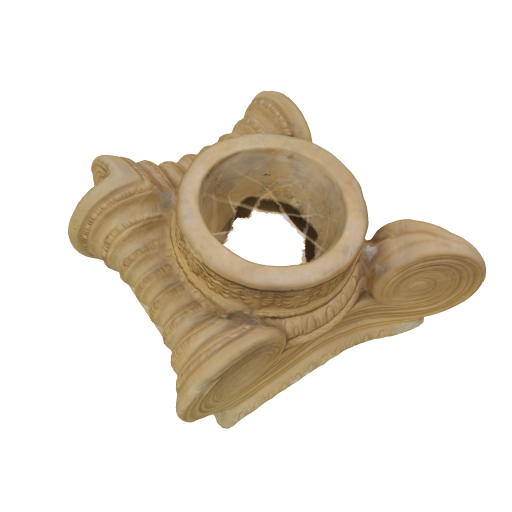

In [11]:
dataset_raw[3]['rgb']

##### Pose
- 4x4 の配列．
- `P[:3, :3]` が回転行列 $R$ で，`P[:3, 3:]` が平行移動ベクトル $\bf{t}$．

In [12]:
dataset_raw[3]['pose']

array([[ 0.635549,  0.678067, -0.369193,  0.627628],
       [-0.      ,  0.478191,  0.878256, -1.49303 ],
       [-0.772061,  0.558174, -0.303914,  0.516654],
       [-0.      , -0.      , -0.      ,  1.      ]], dtype=float32)

##### レンダリング領域の確認
レンダリング領域 $t_n, t_f$ を定めるためにカメラの位置をプロットしてみます．  
オブジェクトは原点中心にあるぽいので，`t_n=0.`, `t_f=2.5` くらいに取っておけば問題なさそうです．

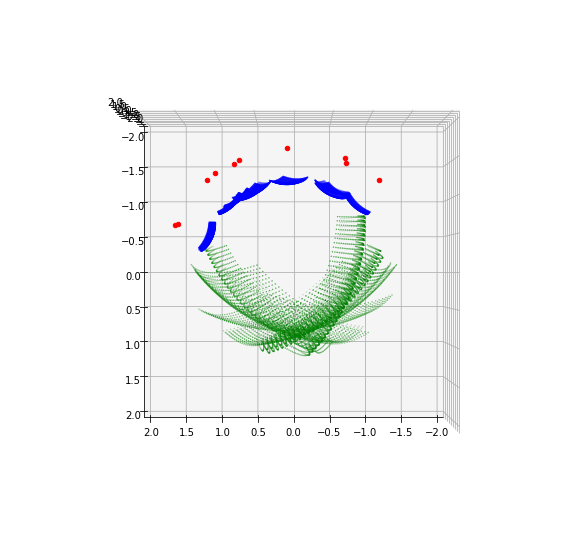

In [13]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_zlim(-2, 2)
ax.view_init(elev=90, azim=90)

for data in dataset_raw[::16]:
    o, d = camera_params_to_rays(f, cx, cy, data['pose'], width, height)

    # 焦点（赤）
    o_x, o_y, o_z = o[0, :1].T
    if np.abs(o_z) > 0.5:
        continue
    ax.scatter(o_x, o_y, o_z, c='red')

    # レンダリング下限（青）
    t_n = .5
    x_n, y_n, z_n = (o + d * t_n)[::16, ::16].reshape(-1, 3).T
    ax.scatter(x_n, y_n, z_n, c='blue', s=0.1)

    # レンダリング上限（緑）
    t_f = 2.5
    x_f, y_f, z_f = (o + d * t_f)[::16, ::16].reshape(-1, 3).T
    ax.scatter(x_f, y_f, z_f, c='green', s=0.1)

### NeRF Loss の入力の形にデータを整形しておく
- 各光線の $\bf o, d$ を計算してけばよい．
- そこそこ時間がかかるので `.npz` で保存しておきます．

In [14]:
os = []
ds = []
Cs = []

for data in dataset_raw:
    pose = data['pose']
    rgb = data['rgb']

    o, d = camera_params_to_rays(f, cx, cy, pose, width, height)
    C = (np.array(rgb, dtype=np.float32) / 255.)[:, :, :3]

    o = o.reshape(-1, 3)
    d = d.reshape(-1, 3)
    C = C.reshape(-1, 3)

    os.append(o)
    ds.append(d)
    Cs.append(C)

os = np.concatenate(os)
ds = np.concatenate(ds)
Cs = np.concatenate(Cs)

dataset = {'o': os, 'd': ds, 'C': Cs}

# 保存しておく
np.savez('./dataset.npz', **dataset)

保存したデータセットを読み込む．二度目以降はこのセルだけ実行すればよい．

In [15]:
_dataset = np.load('./dataset.npz')
dataset = {'o': _dataset['o'], 'd': _dataset['d'], 'C': _dataset['C']}

## 学習
- バッチサイズは `2048` （論文の半分）に設定しています．たぶんもう少し下げても問題ない．
- 学習率のスケジューリングを設定していないので，学習の進捗を見ながら主導で下げてください．2 epoch くらい回ったタイミングで `1/10` すればよいです．

### 設定

In [16]:
n_epoch = 10
batch_size = 2048

### model と optimizer の初期化
- `c_bg` は背景色です．今回は白なので `(1, 1, 1)` にセットしています．
- 個人的に Adam の学習率は `3e-4` が好きです．論文だと `5e-4` から初めてますが．

In [17]:
nerf = NeRF(t_n=0., t_f=2.5, c_bg=(1, 1, 1))
loss_func = NeRFLoss(nerf)

optimizer = torch.optim.Adam(
    loss_func.parameters(),
    lr=3e-4, betas=(0.9, 0.999), eps=1e-7)

loss_func.cuda('cuda:0')
None

### 学習ループ

In [18]:
# # スナップショットの読み込み
# checkpoint = torch.load('./train.state')

# loss_func.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [19]:
# # 学習率の変更
# for pg in optimizer.param_groups:
#      pg['lr'] = 3e-5

In [ ]:
n_sample = dataset['o'].shape[0]

for e in range(1, n_epoch+1):
    print('epoch: {}'.format(e))
    perm = np.random.permutation(n_sample)
    sum_loss = 0.
    sum_loss100 = 0.

    for i in range(0, n_sample, batch_size):
        o = dataset['o'][perm[i:i+batch_size]]
        d = dataset['d'][perm[i:i+batch_size]]
        C = dataset['C'][perm[i:i+batch_size]]

        loss = loss_func(o, d, C)
        sum_loss += loss.item() * o.shape[0]
        sum_loss100 += loss.item()

        if (i / batch_size) % 100 == 99:
            print(sum_loss100 / 100.)
            sum_loss100 = 0.

        loss_func.zero_grad()
        loss.backward()
        optimizer.step()

    print('sum loss: {}'.format(sum_loss / n_sample))

    # save state.
    torch.save({
        'model_state_dict': loss_func.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, './epoch_{}.state'.format(e))


In [22]:
# # スナップショット保存
# torch.save({
#     'model_state_dict': loss_func.state_dict(),
#     'optimizer_state_dict': optimizer.state_dict()
# }, './train.state'.format(e))

## 評価

### レンダリングしてオリジナル画像と比べてみる

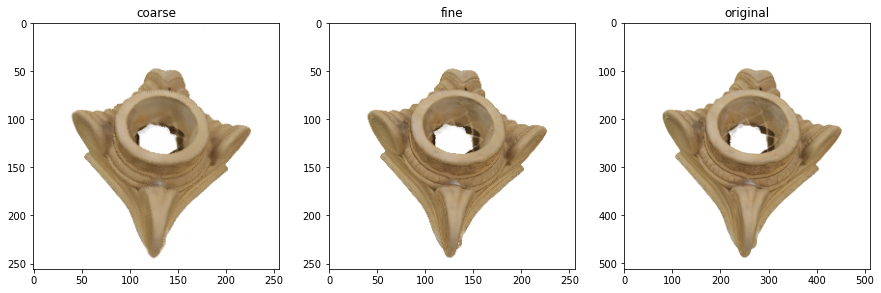

In [23]:
ind = 200
pose = dataset_raw[ind]['pose']
rgb = dataset_raw[ind]['rgb']

# 512 * 512 はやや時間がかかるので半分のサイズでレンダリング
view = {
    'f': f / 2,
    'cx': cy / 2,
    'cy': cy / 2,
    'height': height // 2,
    'width': width // 2,
    'pose': pose
}

# original size.
# view = {
#     'f': f,
#     'cx': cy,
#     'cy': cy,
#     'height': height,
#     'width': width,
#     'pose': pose
# }

C_c, C_f = nerf(view)

# show.
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title('coarse')
plt.imshow(C_c)

plt.subplot(1, 3, 2)
plt.title('fine')
plt.imshow(C_f)

plt.subplot(1, 3, 3)
plt.title('original')
plt.imshow(rgb)

plt.show()

### 回転させてみる

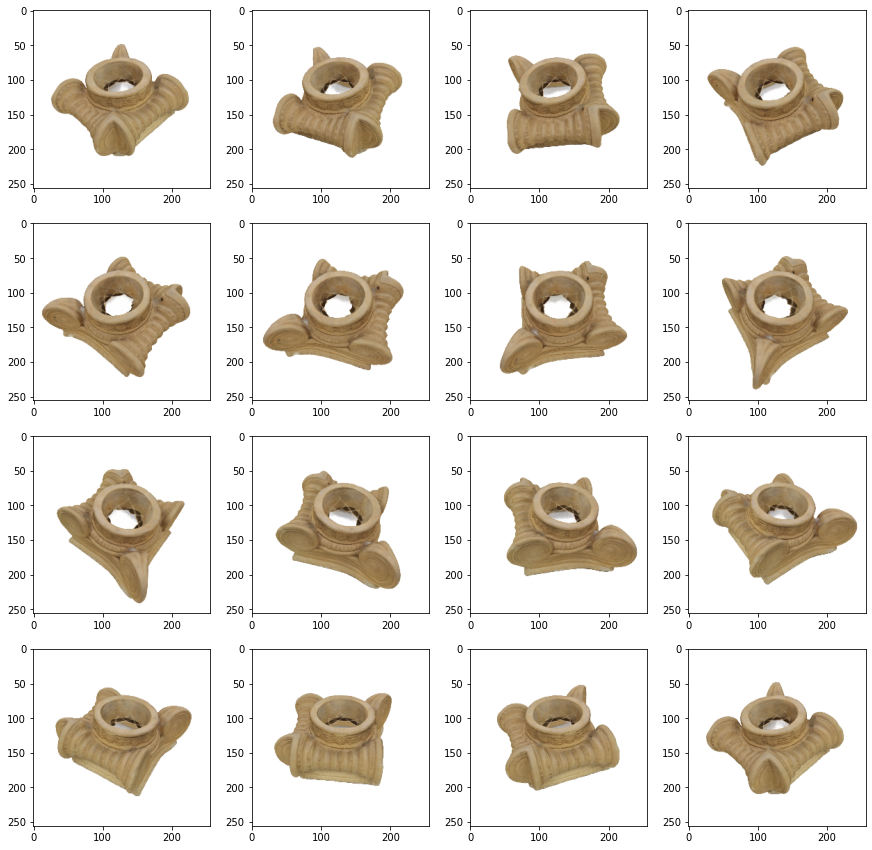

In [24]:
plt.figure(figsize=(15, 15))

for ind, a in enumerate(np.linspace(-np.pi, np.pi, 16)):
    c = np.cos(a)
    s = np.sin(a)

    # y軸回り
    R = np.array([[c, 0, -s, 0],
                  [0, 1,  0, 0],
                  [s, 0,  c, 0],
                  [0, 0,  0, 1]], dtype=np.float32)

#     # z軸回り
#     R = np.array([[c, -s, 0, 0],
#                   [s,  c, 0, 0],
#                   [0,  0, 1, 0],
#                   [0,  0, 0, 1]], dtype=np.float32)

    _view = view.copy()
    _view['pose'] = R @ view['pose']

    C_c, C_f = nerf(_view)

    plt.subplot(4, 4, ind+1)
    plt.imshow(C_f)

plt.show()

### アニメーションを作る

In [25]:
images = []

for ind, a in enumerate(np.linspace(-np.pi, np.pi, 65)[:-1]):
    print(ind, end=', ')

    c = np.cos(a)
    s = np.sin(a)

    # y軸回り
    R = np.array([[c, 0, -s, 0],
                  [0, 1,  0, 0],
                  [s, 0,  c, 0],
                  [0, 0,  0, 1]], dtype=np.float32)

#     # z軸回り
#     R = np.array([[c, -s, 0, 0],
#                   [s,  c, 0, 0],
#                   [0,  0, 1, 0],
#                   [0,  0, 0, 1]], dtype=np.float32)

    _view = view.copy()
    _view['pose'] = R @ view['pose']

    C_c, C_f = nerf(_view)

    image = Image.fromarray((C_f * 255.).astype(np.uint8))
    images.append(image)

# APNG版
images[0].save('./greek.png', save_all=True, append_images=images[1:],
               duration=125, loop=0)
# GIF版
images[0].save('./greek.gif', save_all=True, append_images=images[1:],
               duration=125, loop=0)


0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 

<img src="./greek.png" />